In [1]:
import pandas as pd
import deepchem as dc
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from deepchem import metrics
from IPython.display import Image, display
from rdkit.Chem.Draw import SimilarityMaps
import tensorflow as tf


In [2]:
DATASET_FILE ='/Users/yanlixu/Desktop/git_code/deepchem_for_dti_prediction/data/toxicity_bbb/logBB.sdf'
# Create RDKit mol objects, since we will need them later.
mols = [m for m in Chem.SDMolSupplier(DATASET_FILE) if m is not None ]
loader = dc.data.SDFLoader(tasks=["logBB_class"], 
                           featurizer=dc.feat.ConvMolFeaturizer(),
                           sanitize=True)
dataset = loader.create_dataset(DATASET_FILE, shard_size=2000)

In [3]:
np.random.seed(2020)
tf.random.set_seed(2020)

In [4]:
m = dc.models.GraphConvModel(1, mode="classification", batch_normalize=False, batch_size=100)
m.fit(dataset, nb_epoch=10)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/opt/anaconda3/envs/deepchem/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_14:0", shape=(1771,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_13:0", shape=(1771, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/opt/anaconda3/envs/deepchem/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_17:0", shape=(290,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_16:0", shap

/opt/anaconda3/envs/deepchem/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool/Reshape_14:0", shape=(1771,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool/Reshape_13:0", shape=(1771, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/opt/anaconda3/envs/deepchem/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool/Reshape_17:0", shape=(290,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool/Reshape_16:0", shape=(290, 64

/opt/anaconda3/envs/deepchem/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_14:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_13:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/opt/anaconda3/envs/deepchem/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_17:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_16:0", sha

0.4441966533660889

In [6]:
TEST_DATASET_FILE = '/Users/yanlixu/Desktop/git_code/deepchem_for_dti_prediction/data/toxicity_bbb/logBB.sdf'
loader = dc.data.SDFLoader(tasks=["logBB_class"], sanitize=True,
                           featurizer=dc.feat.ConvMolFeaturizer())
test_dataset = loader.create_dataset(TEST_DATASET_FILE, shard_size=2000)
pred =  m.predict(test_dataset)
pred = np.argmax(np.squeeze(pred),axis=1)
ba = metrics.balanced_accuracy_score(y_true=test_dataset.y, y_pred=pred)
print(ba)

0.7929009193054137


In [7]:
loader = dc.data.SDFLoader(tasks=[],# dont need task (moreover, passing the task can lead to inconsitencies in data shapes)
                        featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=True),
                        sanitize=True) 
frag_dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)

/opt/anaconda3/envs/deepchem/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/deepchem/lib/python3.8/site-packages/deepchem/data/data_loader.py:789: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(features), valid_inds


In [8]:
print(frag_dataset.X.shape)

(321,)


In [9]:
tr = dc.trans.FlatteningTransformer(frag_dataset)
frag_dataset = tr.transform(frag_dataset)
print(frag_dataset.X.shape)

(11200,)


In [10]:
# whole  molecules
pred = np.squeeze(m.predict(dataset))[:, 1] # probabilitiy of class 1
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"])  # turn to dataframe for convinience

# fragments
pred_frags = np.squeeze(m.predict(frag_dataset))[:, 1]
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])

In [11]:
# merge 2 dataframes by molecule names
df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
df['Contrib'] = df["Molecule"] - df["Fragment"]

In [12]:
df

,Fragment,Molecule,Contrib
ClC(Cl)=C(Cl)Cl,0.674076,0.821518,0.147441
ClC(Cl)=C(Cl)Cl,0.674076,0.821518,0.147441
ClC(Cl)=C(Cl)Cl,0.553096,0.821518,0.268421
ClC(Cl)=C(Cl)Cl,0.553096,0.821518,0.268421
ClC(Cl)=C(Cl)Cl,0.553096,0.821518,0.268421
...,...,...,...
[H]n1c(C2([H])C([H])([H])C(=O)C([H])([H])C2([H])[H])nc2c1c(=O)n(C([H])([H])C([H])([H])C([H])([H])[H])c(=O)n2C([H])([H])C([H])([H])C([H])([H])[H],0.330003,0.338973,0.008971
[H]n1c(C2([H])C([H])([H])C(=O)C([H])([H])C2([H])[H])nc2c1c(=O)n(C([H])([H])C([H])([H])C([H])([H])[H])c(=O)n2C([H])([H])C([H])([H])C([H])([H])[H],0.330238,0.338973,0.008736
[H]n1c(C2([H])C([H])([H])C(=O)C([H])([H])C2([H])[H])nc2c1c(=O)n(C([H])([H])C([H])([H])C([H])([H])[H])c(=O)n2C([H])([H])C([H])([H])C([H])([H])[H],0.330238,0.338973,0.008736
[H]n1c(C2([H])C([H])([H])C(=O)C([H])([H])C2([H])[H])nc2c1c(=O)n(C([H])([H])C([H])([H])C([H])([H])[H])c(=O)n2C([H])([H])C([H])([H])C([H])([H])[H],0.350350,0.338973,-0.011376


In [13]:
def vis_contribs(mols, df, smi_or_sdf = "sdf"): 
    # input format of file, which was used to create dataset determines the order of atoms, 
    # so we take it into account for correct mapping!
    maps = []
    for mol  in mols:
        wt = {}
        if smi_or_sdf == "smi":
            for n,atom in enumerate(Chem.rdmolfiles.CanonicalRankAtoms(mol)):
                wt[atom] = df.loc[mol.GetProp("_Name"),"Contrib"][n]
        if smi_or_sdf == "sdf":        
            for n,atom in enumerate(range(mol.GetNumHeavyAtoms())):
                #wt[atom] = df.loc[Chem.MolToSmiles(mol),"Contrib"][n]
                wt[atom] = df.loc['ClC(Cl)=C(Cl)Cl',"Contrib"][n]
        maps.append(SimilarityMaps.GetSimilarityMapFromWeights(mol,wt))
    return maps

In [19]:
df.loc['ClC(Cl)=C(Cl)Cl',"Contrib"][0]

0.14744127

In [17]:
np.random.choice(np.array(mols),10)

array([<rdkit.Chem.rdchem.Mol object at 0x7fdb9775e460>,
       <rdkit.Chem.rdchem.Mol object at 0x7fdb975ee6a0>], dtype=object)

In [20]:
np.random.seed(2000)
maps = vis_contribs(np.random.choice(np.array(mols),10), df)

KeyError: 'CCC(C)N1CCN(c2ccc(I)cc2)CC1'

In [57]:
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image

# show one molecule

In [58]:
# show one molecule
m = Chem.MolFromSmiles('Cc1ccccc1')
Draw.MolToFile(m,'cdk2_mol1.png')

# show multiple molecules

In [59]:
# show multiple molecules
ms = ['Cc1ccccc1', 'Cc1ccccc1', 'Cc1ccccc1', 'Cc1ccccc1', 'Cc1ccccc1', 'Cc1ccccc1']
mols = []
for m in ms: 
    mol = Chem.MolFromSmiles(m)
    mol.SetProp("_Name","Molecule")
    mols.append(mol)
#img=Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(200,200),legends=[x for x in mols])
img=Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(200,200), legends=[x.GetProp("_Name") for x in mols])

#img.save('cdk2_molgrid.o.png')   

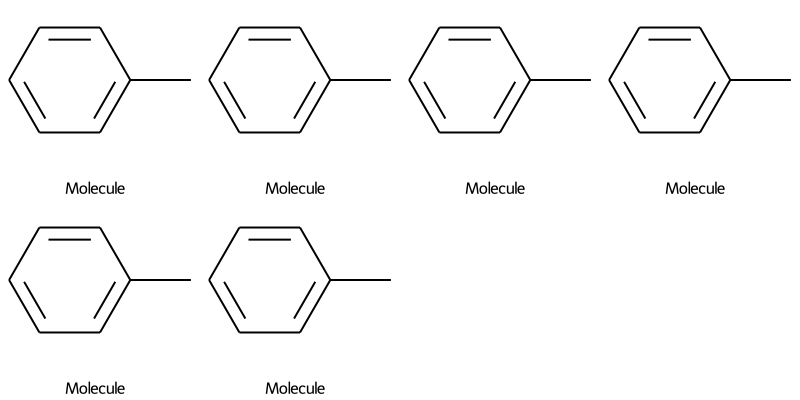

In [60]:
png = img.data
with open('./foo.png','wb+') as outf:
    outf.write(png)
Image.open('./foo.png')

# highlight substructure

In [72]:
from rdkit.Chem.Draw import rdMolDraw2D
smi = 'c1cc(F)ccc1Cl'
mol = Chem.MolFromSmiles(smi)
patt = Chem.MolFromSmarts('ClccccF')
hit_ats = list(mol.GetSubstructMatch(patt))
hit_bonds = []
for bond in patt.GetBonds():
    aid1 = hit_ats[bond.GetBeginAtomIdx()]
    aid2 = hit_ats[bond.GetEndAtomIdx()]
    hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats, highlightBonds=hit_bonds)
d.FinishDrawing()

In [75]:
svg = d.GetDrawingText()
with open('test.svg', 'w') as f:
    f.write(svg)

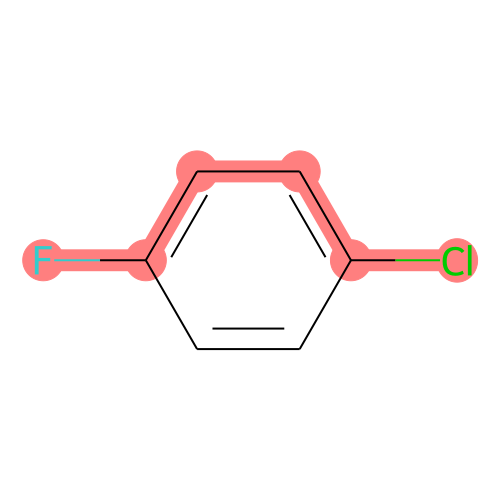

In [79]:
from IPython.core.display import SVG
SVG(filename='test.svg')

# substructure search

In [86]:
m = Chem.MolFromSmiles('c1ccccc1O')
patt = Chem.MolFromSmarts('ccO')
m.HasSubstructMatch(patt)

True

In [87]:
m.GetSubstructMatch(patt)

(0, 5, 6)

In [88]:
m.GetSubstructMatches(patt)

((0, 5, 6), (4, 5, 6))

In [89]:
m = Chem.MolFromSmiles('CC[C@H](F)Cl')

In [90]:
m.HasSubstructMatch(Chem.MolFromSmiles('C[C@H](F)Cl'),useChirality=True)

True

# find max common structure

In [91]:
from rdkit.Chem import rdFMCS
mol1 = Chem.MolFromSmiles("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C")
mol2 = Chem.MolFromSmiles("CC(C)CCCCCC(=O)NCC1=CC(=C(C=C1)O)OC")
mol3 = Chem.MolFromSmiles("c1(C=O)cc(OC)c(O)cc1")
mols = [mol1,mol2,mol3]
res=rdFMCS.FindMCS(mols)
res

In [94]:
res.smartsString

'[#6]1(-[#6]):[#6]:[#6](-[#8]-[#6]):[#6](:[#6]:[#6]:1)-[#8]'

In [95]:
mols = (Chem.MolFromSmiles('NCC'),Chem.MolFromSmiles('OC=C'))
rdFMCS.FindMCS(mols).smartsString

'[#6]'

In [96]:
rdFMCS.FindMCS(mols, atomCompare=rdFMCS.AtomCompare.CompareAny).smartsString

'[#7,#8]-[#6]'

In [97]:
rdFMCS.FindMCS(mols, bondCompare=rdFMCS.BondCompare.CompareAny).smartsString

'[#6]-,=[#6]'

# finger print

In [98]:
from rdkit import DataStructs
ms = [Chem.MolFromSmiles('CCOC'), Chem.MolFromSmiles('CCO'),Chem.MolFromSmiles('COC')]
fps = [Chem.RDKFingerprint(x) for x in ms]

In [101]:
# method 1
DataStructs.FingerprintSimilarity(fps[0],fps[1])

0.6

In [102]:
# method 2
from rdkit.Chem import MACCSkeys
fps = [MACCSkeys.GenMACCSKeys(x) for x in ms]
DataStructs.FingerprintSimilarity(fps[0],fps[1])

0.5

In [105]:
# method 3
from rdkit.Chem import AllChem
m1 = Chem.MolFromSmiles('Cc1ccccc1')
fp1 = AllChem.GetMorganFingerprint(m1,2)
m2 = Chem.MolFromSmiles('Cc1ncccc1')
fp2 = AllChem.GetMorganFingerprint(m2,2)
DataStructs.DiceSimilarity(fp1,fp2)

0.55

In [106]:
fp1 = AllChem.GetMorganFingerprintAsBitVect(m1,2,nBits=1024)
fp2 = AllChem.GetMorganFingerprintAsBitVect(m2,2,nBits=1024)
DataStructs.DiceSimilarity(fp1,fp2)

0.5185185185185185

In [107]:
m1 = Chem.MolFromSmiles('c1ccccn1')
m2 = Chem.MolFromSmiles('c1ccco1')
fp1 = AllChem.GetMorganFingerprint(m1,2)
fp2 = AllChem.GetMorganFingerprint(m2,2)
ffp1 = AllChem.GetMorganFingerprint(m1,2,useFeatures=True)
ffp2 = AllChem.GetMorganFingerprint(m2,2,useFeatures=True)
DataStructs.DiceSimilarity(fp1,fp2)

0.36363636363636365

In [108]:
DataStructs.DiceSimilarity(ffp1,ffp2)

0.9090909090909091

# Generating Similarity Maps Using Fingerprints

In [110]:
from rdkit import Chem
mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
refmol = Chem.MolFromSmiles('CCCN(CCCCN1CCN(c2ccccc2OC)CC1)Cc1ccc2ccccc2c1')

In [111]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
fp = SimilarityMaps.GetMorganFingerprint(mol, fpType='bv')

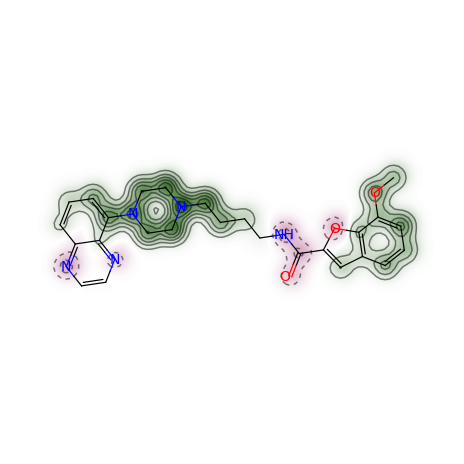

In [112]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint)

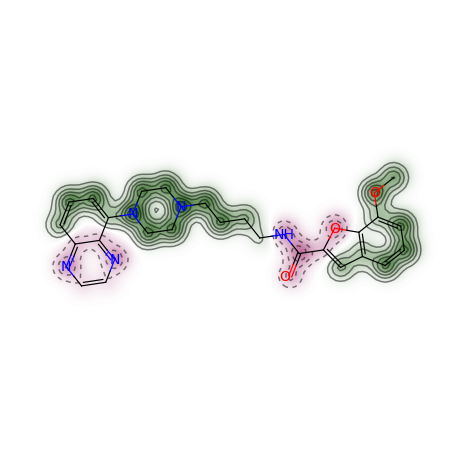

In [113]:
from rdkit import DataStructs
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=1, fpType='count'), metric=DataStructs.TanimotoSimilarity)

In [117]:
weights = SimilarityMaps.GetAtomicWeightsForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint)
print(["%.2f " % w for w in weights])

['0.05 ', '0.07 ', '0.05 ', '0.08 ', '0.05 ', '0.06 ', '0.03 ', '0.04 ', '-0.01 ', '-0.04 ', '-0.03 ', '-0.05 ', '0.01 ', '0.03 ', '0.07 ', '0.10 ', '0.12 ', '0.11 ', '0.09 ', '0.10 ', '0.09 ', '0.06 ', '0.03 ', '0.02 ', '-0.01 ', '-0.05 ', '0.00 ', '0.00 ', '-0.03 ', '0.02 ', '0.09 ', '0.11 ', '-0.04 ', '0.04 ']


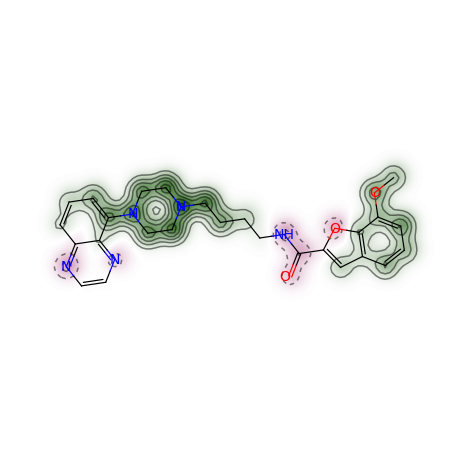

In [118]:
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, weights)

# descriptor maps

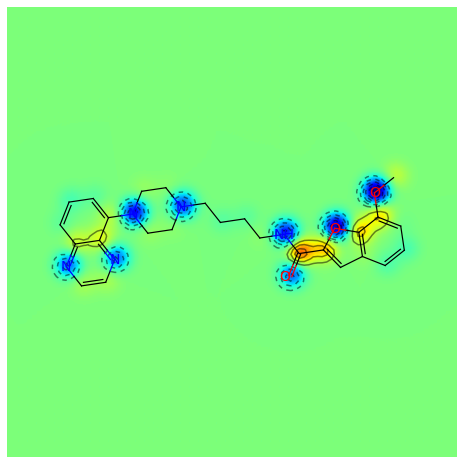

In [126]:
from rdkit.Chem.Draw import SimilarityMaps
mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
AllChem.ComputeGasteigerCharges(mol)
contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap='jet', contourLines=10)

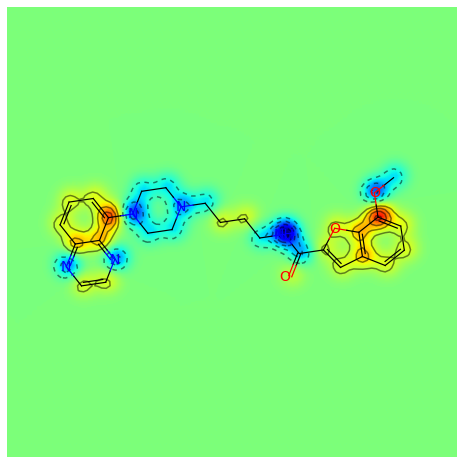

In [128]:
from rdkit.Chem import rdMolDescriptors
contribs = rdMolDescriptors._CalcCrippenContribs(mol)
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol,[x for x,y in contribs], colorMap='jet', contourLines=10)